Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lun\.medmnist\pneumoniamnist.npz
開始訓練... 使用裝置: cuda
Epoch 1/10 - Loss: 0.2296 - Val Acc: 0.9654
Epoch 2/10 - Loss: 0.0953 - Val Acc: 0.9714
Epoch 3/10 - Loss: 0.0757 - Val Acc: 0.9729
Epoch 4/10 - Loss: 0.0593 - Val Acc: 0.9684
Epoch 5/10 - Loss: 0.0572 - Val Acc: 0.9804
Epoch 6/10 - Loss: 0.0452 - Val Acc: 0.9774
Epoch 7/10 - Loss: 0.0418 - Val Acc: 0.9849
Epoch 8/10 - Loss: 0.0321 - Val Acc: 0.9834
Epoch 9/10 - Loss: 0.0324 - Val Acc: 0.9473
Epoch 10/10 - Loss: 0.0284 - Val Acc: 0.9759


C:\Users\lun\AppData\Local\Temp\ipykernel_15444\2561037967.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_fusion_model.pth"))



=== Final Test Report ===
              precision    recall  f1-score   support

      Normal       0.99      0.79      0.88       234
   Pneumonia       0.89      0.99      0.94       390
Tuberculosis       1.00      1.00      1.00       140

    accuracy                           0.93       764
   macro avg       0.96      0.93      0.94       764
weighted avg       0.94      0.93      0.93       764



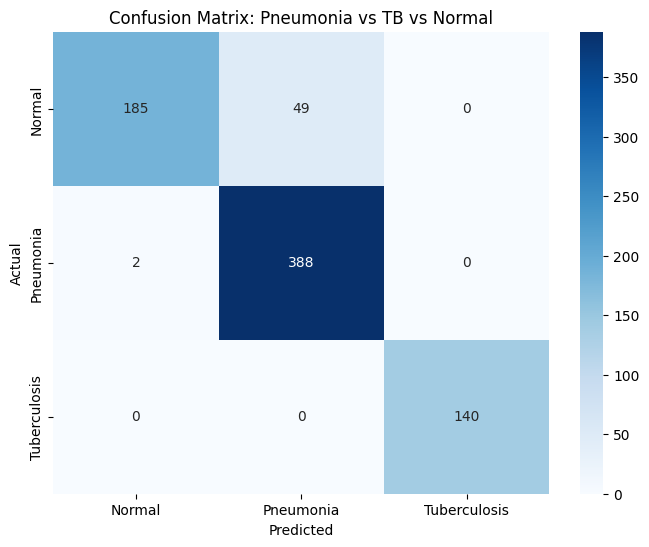

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from medmnist import PneumoniaMNIST, INFO

# ==========================================
# 1. 環境設定與超參數
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir_tb = "./TB_Chest"  # 本地 TB 資料路徑
img_size = (224, 224)
batch_size = 32
epochs = 10
learning_rate = 1e-4
num_classes = 3  # 0: Normal, 1: Pneumonia, 2: TB

# ==========================================
# 2. 資料準備：整合 MNIST 與 本地 TB 資料
# ==========================================

# A. 提取本地 TB 資料 (Label 2)
tb_filepaths = []
for root, dirs, files in os.walk(data_dir_tb):
    # 只取 Tuberculosis 資料夾下的影像
    if "Tuberculosis" in root:
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                tb_filepaths.append(os.path.join(root, file))

tb_df = pd.DataFrame({'path': tb_filepaths, 'label': 2})
train_tb_df, test_tb_df = train_test_split(tb_df, test_size=0.2, random_state=42)

# B. 自定義 Dataset 類別
class MultiDiseaseDataset(Dataset):
    def __init__(self, data_source, transform=None, is_mnist=False):
        self.data_source = data_source
        self.transform = transform
        self.is_mnist = is_mnist

    def __len__(self):
        return len(self.data_source)

    def __getitem__(self, idx):
        if self.is_mnist:
            # MedMNIST 回傳 (PIL Image, ndarray label)
            img, label = self.data_source[idx]
            img = img.convert('RGB')
            label = int(label[0]) # 0 或 1
        else:
            # 本地 DF 讀取
            img_path = self.data_source.iloc[idx]['path']
            img = Image.open(img_path).convert('RGB')
            label = self.data_source.iloc[idx]['label'] # 2
        
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# C. 定義轉換 (Transforms)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# D. 建立整合數據集
# 載入 PneumoniaMNIST (0: Normal, 1: Pneumonia)
mnist_train = PneumoniaMNIST(split="train", download=True)
mnist_val = PneumoniaMNIST(split="val", download=True)
mnist_test = PneumoniaMNIST(split="test", download=True)

train_set = ConcatDataset([
    MultiDiseaseDataset(mnist_train, transform=train_transform, is_mnist=True),
    MultiDiseaseDataset(train_tb_df, transform=train_transform, is_mnist=False)
])

val_set = ConcatDataset([
    MultiDiseaseDataset(mnist_val, transform=test_transform, is_mnist=True),
    MultiDiseaseDataset(test_tb_df, transform=test_transform, is_mnist=False) # TB 用測試集一部分當驗證
])

test_set = ConcatDataset([
    MultiDiseaseDataset(mnist_test, transform=test_transform, is_mnist=True),
    MultiDiseaseDataset(test_tb_df, transform=test_transform, is_mnist=False)
])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# ==========================================
# 3. 模型定義 (融合 main.ipynb 的架構)
# ==========================================
def get_model(model_name="convnext_tiny"):
    if model_name == "convnext_tiny":
        model = models.convnext_tiny(weights=True)
        # 修改最後一層為 3 類輸出
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vit_b_16":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model.to(device)

model = get_model("resnet50") # 可切換 resnet50 或 vit_b_16




# ==========================================
# 4. 訓練與評估函式
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_labels, all_preds

# ==========================================
# 5. 開始執行訓練
# ==========================================
print(f"開始訓練... 使用裝置: {device}")
best_acc = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    
    val_acc, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_set):.4f} - Val Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_fusion_model.pth")

# ==========================================
# 6. 最終結果與混淆矩陣
# ==========================================
model.load_state_dict(torch.load("best_fusion_model.pth"))
acc, y_true, y_pred = evaluate(model, test_loader)

print("\n=== Final Test Report ===")
target_names = ['Normal', 'Pneumonia', 'Tuberculosis']
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix: Pneumonia vs TB vs Normal")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()